# MNIST_example.ipynb
 Work through a basic restricted Boltzmann machine with the MNIST handwriting database
###  Kat Nykiel
Adapted from https://blog.paperspace.com/beginners-guide-to-boltzmann-machines-pytorch/
### running this notebook
- requires the 'Jupyter Notebook with Anaconda 2020.11' nanoHUB tool
- requires the 'Python3 (MXMNET)' kernel
- requires MNIST data to be located in ./MNIST (unpacked MNIST.tar.gz from https://www.di.ens.fr/~lelarge/MNIST.tar.gz)

## import required libraries

In [2]:
import numpy as np
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
%matplotlib inline
import matplotlib.pyplot as plt

## load MNIST dataset

In [23]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
datasets.MNIST('./',
    train=True,
    download = True,
    transform = transforms.Compose(
        [transforms.ToTensor()])
     ),
     batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
datasets.MNIST('./',
    train=False,
    transform=transforms.Compose(
    [transforms.ToTensor()])
    ),
    batch_size=batch_size)


## define restricted Boltzmann machine

In [24]:
class RBM(nn.Module):
   def __init__(self,
               n_vis=784,
               n_hin=500,
               k=5):
        super(RBM, self).__init__()
        self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2)
        self.v_bias = nn.Parameter(torch.zeros(n_vis))
        self.h_bias = nn.Parameter(torch.zeros(n_hin))
        self.k = k
    
   def sample_from_p(self,p):
       return F.relu(torch.sign(p - Variable(torch.rand(p.size()))))
    
   def v_to_h(self,v):
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        sample_h = self.sample_from_p(p_h)
        return p_h,sample_h
    
   def h_to_v(self,h):
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        sample_v = self.sample_from_p(p_v)
        return p_v,sample_v
        
   def forward(self,v):
        pre_h1,h1 = self.v_to_h(v)
        
        h_ = h1
        for _ in range(self.k):
            pre_v_,v_ = self.h_to_v(h_)
            pre_h_,h_ = self.v_to_h(v_)
        
        return v,v_
    
   def free_energy(self,v):
        vbias_term = v.mv(self.v_bias)
        wx_b = F.linear(v,self.W,self.h_bias)
        hidden_term = wx_b.exp().add(1).log().sum(1)
        return (-hidden_term - vbias_term).mean()



## train the model
- TODO: this is fairly slow to run in the nanoHUB front end, look into using !submit

Training loss for 0 epoch: -8.431360244750977
Training loss for 1 epoch: -6.610493183135986
Training loss for 2 epoch: -4.569840908050537
Training loss for 3 epoch: -3.1860601902008057
Training loss for 4 epoch: -2.1829617023468018
Training loss for 5 epoch: -1.543567180633545
Training loss for 6 epoch: -1.105465054512024
Training loss for 7 epoch: -0.7460358142852783
Training loss for 8 epoch: -0.4700148403644562
Training loss for 9 epoch: -0.3517167568206787


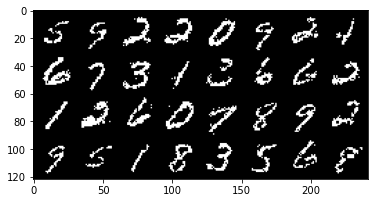

In [38]:
rbm = RBM(k=1)
train_op = optim.SGD(rbm.parameters(),0.1)

for epoch in range(10):
    loss_ = []
    for _, (data,target) in enumerate(train_loader):
        data = Variable(data.view(-1,784))
        sample_data = data.bernoulli()
        
        v,v1 = rbm(sample_data)
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        loss_.append(loss.data)
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        
    print("Training loss for {} epoch: {}".format(epoch, np.mean(loss_)))


## view results

In [42]:
def show_adn_save(file_name,img):
    npimg = np.transpose(img.numpy(),(1,2,0))
    f = "./MNIST/%s.png" % file_name
    plt.imshow(npimg)
    plt.imsave(f,npimg)

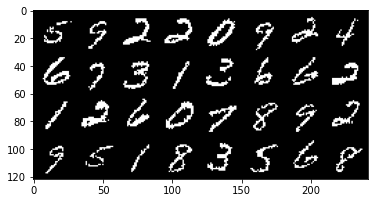

In [43]:
show_adn_save("real",make_grid(v.view(32,1,28,28).data))

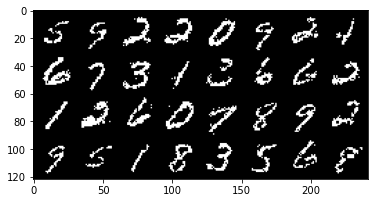

In [44]:
show_adn_save("generate",make_grid(v1.view(32,1,28,28).data))